In [15]:
import pandas as pd
import numpy as np
import glob
from scipy.stats import multivariate_normal
from scipy.spatial import KDTree
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from sklearn.metrics import adjusted_rand_score

In [16]:
# take input from user
type_scribble = input("Enter 1.expert, 2.mclust_backbone: ")
sample_name = input("Enter sample name ie.bcdc_ffpe,Melanoma,[1515(07-10)],[1516(69-76)] :")

if type_scribble == "1":
    type_scribble = "Expert_scribble"
elif type_scribble == "2":
    type_scribble = "Mclust_scribble"

print("type_scribble: ", type_scribble)
print("sample_name: ", sample_name)

type_scribble:  Expert_scribble
sample_name:  bcdc


In [17]:
def NN_graph_index(X, NN = 6):
    # X = coordinates, size N x D
    # NN = number of nearest neighbors
    kt = KDTree(X)
    G_idx = kt.query(X, NN+1)[1][:, 1:]
    return G_idx

In [18]:
def calculate_p_D(labels, G_idx, gamma=3, NN = 6):
    def hist_1d(a):
        return np.histogram(a, bins=label_bins)[0]
    
    r = labels[G_idx.ravel()].reshape(-1, NN)
    label_bins = np.arange(df["label"].unique().shape[0] + 5)
    counts = np.apply_along_axis(hist_1d, axis=1, arr=r)
    p = np.exp(gamma*counts/NN)
    norm_fact = p.sum(axis=1).reshape(-1, 1)
    p /= norm_fact
    p_D = p[np.arange(len(p)), labels]
    return p_D

In [19]:
def calculate_p_y_given_D(x):
    mu = x.mean(axis=0)
    Sigma = np.cov(x, rowvar=False, bias=True)
    #Sigma = np.diag(np.diag(Sigma))
    p_y_given_D = multivariate_normal.pdf(x, mean=mu, cov=Sigma,allow_singular=True)
    return p_y_given_D

In [20]:
# fname_out_root = "Outputs/{}/*/"
fname_out_root = "../Outputs/*/*/{}/"+type_scribble+"*/*/*/*/*/"

In [21]:
def get_Human_DLPFC_filenames(dataset, fname_out_root):
    fname = {}
    fname["data"] = dataset + "/pcs.csv"
    fname["spatial"] = dataset + "/coordinates.csv"
    fname["labels"] = np.sort(glob.glob(fname_out_root.format(dataset) + "final_barcode_labels.csv"))
    fname["ari"] = np.sort(glob.glob(fname_out_root.format(dataset) + "final_metrics.csv"))
    fname["meta"] = np.sort(glob.glob(fname_out_root.format(dataset) + "meta_data.csv"))
    return fname

# Main Code

In [22]:
datasets = [d for d in glob.glob(sample_name+"*") if ".csv" not in d]
print(datasets)

['bcdc_ffpe']


In [23]:
# print(fname_out_root.format(datasets[0]) + "final_metrics.csv")
# glob.glob(fname_out_root.format(datasets[0]) + "final_metrics.csv")
# glob.glob('Outputs/*/*/{}/*/*/*/*/*/'.format('1_Melanoma'))

In [24]:
df_results = {}
var_results = {}
for n in range(len(datasets)):
    print(n)
   
    fname = get_Human_DLPFC_filenames(datasets[n], fname_out_root)

    # print(fname)
    
    df = pd.read_csv(fname["data"], index_col=0)
    X = pd.read_csv(fname["spatial"], index_col = 0).values
    Graph_index = NN_graph_index(X)
    
    df_result = pd.DataFrame({})

    var_results[datasets[n]] = {}
    for i in range(len(fname["labels"])):
        # uneder_cluster = pd.read_csv(fname["ari"][i], index_col=0).T.loc["under_cluster", 0]
        # if uneder_cluster == 1:
        #     continue

        df_label = pd.read_csv(fname["labels"][i], index_col=0)
        df["label"] = df_label.loc[df.index]#df_label.values 
        
        
        df_meta = pd.read_csv(fname["meta"][i], index_col=0).T
        ari = pd.read_csv(fname["ari"][i], index_col=0).T.loc["ARI", 0]
        df_meta["ari"] = ari

        # calculating spatial probability 
        df["p_D"] = calculate_p_D(df["label"].values, Graph_index)

        ll_joint = 0
        ll_cond = 0
        # ll_scaled = 0
        
        # test
        hyper_name = fname["labels"][i].split("/")[-2]
        var_results[datasets[n]][hyper_name] = {}
        for c in df["label"].unique():
            df_c = df.groupby("label").get_group(c)
            p_D = df_c.iloc[:, -1].values
                                                 
            x = df_c.iloc[:, :-2].values
            if x.shape[0] == 1: continue
            p_y_given_D = calculate_p_y_given_D(x)
            
            # test
            var_c = np.diag(np.cov(x, rowvar=False, bias=True)).sum()
            var_results[datasets[n]][hyper_name][c] = var_c
            #print(datasets[n], "-", fname["labels"][i].split("/")[-2], "-", c, "-", p_y_given_D.min(), p_D.min())
            
            p_joint = p_y_given_D*p_D
            
            
            ll_joint += np.log(p_joint).sum()
            ll_cond += np.log(p_y_given_D).sum()
            # ll_scaled += np.log(p_joint/var_c).sum()
            
        df_meta["log-likelihood_joint"] = ll_joint
        df_meta["log-likelihood_conditional"] = ll_cond
        # df_meta["log-likelihood_scaled"] = ll_scaled
        df_meta["variance"] = sum(var_results[datasets[n]][hyper_name].values())


        df_result = pd.concat([df_result, df_meta], ignore_index=True)
        
    df_results[datasets[n]] = df_result
    # df_result.to_csv(datasets[n] + "_results.csv", index=False)



0


In [25]:
map_visualization = {}
list_visualization = []

bcdc_ffpe : (alpha,beta) = (0.8,None)
bcdc_ffpe : ARI = 0.8063069710010103


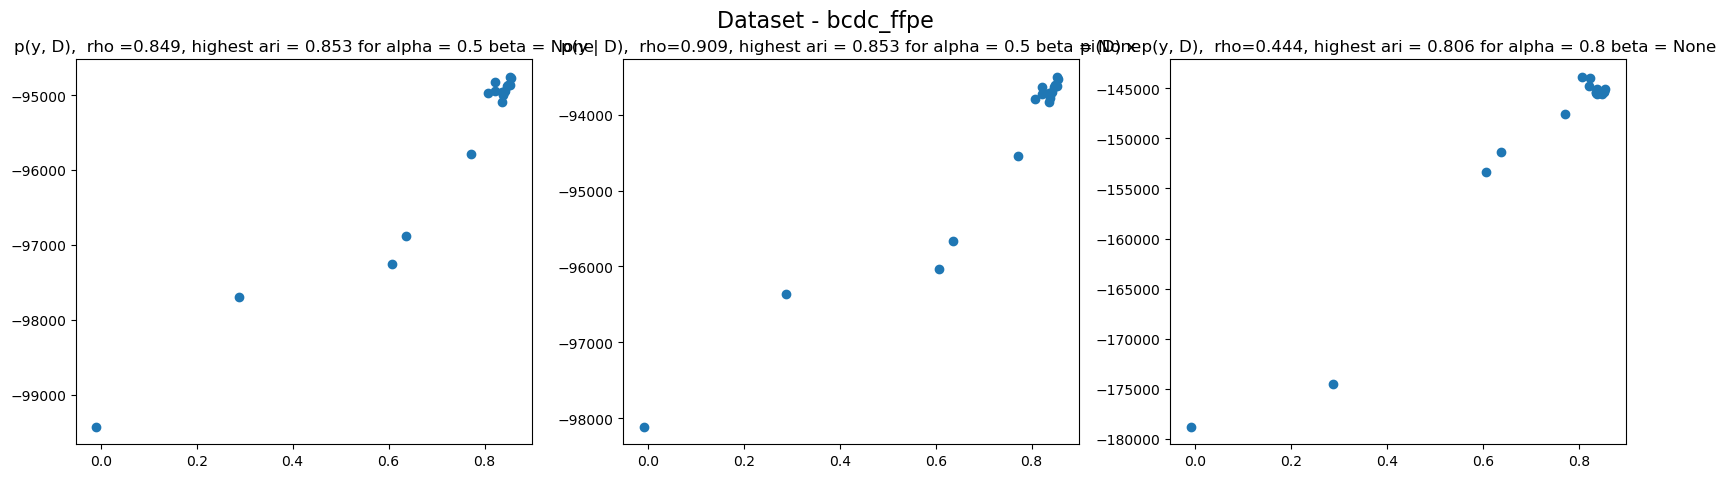

In [26]:
figs = {}
axes = {}

ari_joint = []
ari_cond = []
ari_scaled = []
ari_max = []

for key in np.sort(list(df_results.keys())):
    y1 = df_results[key]["log-likelihood_joint"]
    y2 = df_results[key]["log-likelihood_conditional"]
    # y3 = df_results[key]["log-likelihood_scaled"]
    y3 = df_results[key]["log-likelihood_joint"] - df_results[key]["variance"]*100
    
    idx1 = np.argmax(y1)
    idx2 = np.argmax(y2)
    idx3 = np.argmax(y3)
    
    x = df_results[key]["ari"].values
    
    pr1, _ = spearmanr(x, y1)
    pr2, _ = spearmanr(x, y2)
    pr3, _ = spearmanr(x, y3)
    
    g1 = x[idx1]
    g2 = x[idx2]
    g3 = x[idx3]
    a1 = df_results[key].loc[idx1, "alpha"]
    a2 = df_results[key].loc[idx2, "alpha"]
    a3 = df_results[key].loc[idx3, "alpha"]

    b1,b2,b3 = None,None,None
    if "beta" in df_results[key].columns:
        b1 = df_results[key].loc[idx1, "beta"]
        b2 = df_results[key].loc[idx2, "beta"]
        b3 = df_results[key].loc[idx3, "beta"]
    
    ari_joint.append(g1)
    ari_cond.append(g2)
    ari_scaled.append(g3)
    ari_max.append(x.max())

    
    fig, ax = plt.subplots(1, 3, figsize=(20, 5))
    
    ax[0].scatter(x, y1)
    ax[0].set_title(f"p(y, D),  rho ={pr1:0.3f}, highest ari = {g1:0.3f} for alpha = {a1} beta = {b1}")
    
    ax[1].scatter(x, y2)
    ax[1].set_title(f"p(y | D),  rho={pr2:0.3f}, highest ari = {g2:0.3f} for alpha = {a2} beta = {b2}")
    
    ax[2].scatter(x, y3)
    ax[2].set_title(f"pi(D) x p(y, D),  rho={pr3:0.3f}, highest ari = {g3:0.3f} for alpha = {a3} beta = {b3}")
    
    #fig.tight_layout()
    fig.suptitle(f"Dataset - {key}", fontsize=16)

    # print(key, ":", f"({a1},{b1}), ({a2},{b2}),({a3},{b3}), x.max()")
    # print(key, ":", g1, g2, g3, x.max())
    print(key, ":", f"(alpha,beta) = ({a3},{b3})")
    print(key, ":", f"ARI = {g3}")
    map_visualization['Sample'] = key

    map_visualization['ARI-Joint'] = g1 
    map_visualization['Alpha-Joint'] = a1
    map_visualization['Beta-Joint'] = b1

    map_visualization['ARI-Conditional'] = g2
    map_visualization['Alpha-Conditional'] = a2
    map_visualization['Beta-Conditional'] = b2

    map_visualization['ARI-Scaled'] = g3
    map_visualization['Alpha-Scaled'] = a3
    map_visualization['Beta-Scaled'] = b3

    map_visualization['ARI-Max'] = x.max()

    list_visualization.append(map_visualization.copy())
    
df_visualization = pd.DataFrame(list_visualization)
# df_visualization.to_csv("visualization.csv", index=False)